# Midterm 2:  Python Problems


There are three python problems.  Answer all the sections marked `#TODO`.  Print to PDF.  Submit the PDF only. 

## Loading Packages and Data

For the problems, you can use the following packages

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

Run the following code to download the data for the midterm.  This will retrieve three files -- one for each problem.

In [23]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
file_path = 'https://drive.google.com/file/d/1lGITFTWO4MJ-BcHnfgj5tWFNtMOO6r53/view?usp=sharing'
                
file_path = 'https://drive.google.com/file/d/10_1PxDIoSiuuOFC_iyVaoU9bDiQYHcTT/view?usp=sharing'
file_id = '1lGITFTWO4MJ-BcHnfgj5tWFNtMOO6r53'

dst = 'midterm_data.zip'
download_file_from_google_drive(file_id, dst)


# Unzip the files
import zipfile
with zipfile.ZipFile(dst, 'r') as zip_ref:
    zip_ref.extractall('data')
    
    
# Move them to the top directory
import shutil
for fn in ['prob_opt.p', 'prob_svm.p', 'prob_nn.p']:
    src = 'data/midterm2_data/%s' % fn
    shutil.move(src, fn)
    print('%s loaded' % fn)

prob_opt.p loaded
prob_svm.p loaded
prob_nn.p loaded


## Problem 1.  Nonlinear Optimization

Run the following code to load the data

In [24]:
with open('prob_opt.p', 'rb') as fp:
    X,y = pickle.load(fp)

We want to fit a model of the form:

     z[i] = X[i,0]*w[0] + X[i,1]*w[1]
     yhat[i] = 1/(1+ exp(-z[i]))
     
for parameters `w=[w[0], w[1]]`.  To do this we minimize the loss:

     J(w) = \sum_i (yhat[i] - y[i])**2
     
Complete the following function `Jeval` which returns the `J(w)` and the gradient
`Jgrad`.

In [25]:
def Jeval(w,X,y):
    # Compute Decision and Loss function
    z = X.dot(w)
    yhat = 1 / (1 + np.exp(-z))
    J = np.sum((yhat-y)**2)

    # Compute gradient
    dJ_dyhat = 2*(yhat - y)
    dyhat_dz = np.exp(-z) / (1 + np.exp(-z))**2
    dJ_dw0 = X[:,0].T.dot(dJ_dyhat * dyhat_dz)
    dJ_dw1 = X[:,1].T.dot(dJ_dyhat * dyhat_dz)
    Jgrad = np.array([dJ_dw0, dJ_dw1]) 
    
    return J, Jgrad
    

Test the gradient as follows:
*  Take a random initial condition, `w0` 
*  Take a second random input `w1` close to `w0`
*  Compare `J(w1)-J(w0)` with the expected difference based on the gradient.

In [26]:
# Random point w0
d = X.shape[1]
w0 = np.random.normal(0,1,d)
J0, Jgrad0 = Jeval(w0, X, y)

step = 1e-2
w1 = w0 + step*np.random.normal(0,1,d)
J1, Jgrad1 = Jeval(w1, X, y)
dJ_act = J1 - J0
dJ_exp = Jgrad0.dot(w1-w0)
print(dJ_act)
print(dJ_exp)

0.23876522233335606
0.23822688736207143


Implement basic gradient descent:

*  Start at the initial condition `w0` from above
*  Use a step size of `step=1e-2`
*  On each iteration, `it`, save the loss and the norm squared of the gradient:
       
       Jhist[it] = J
       gnormhist[it] = sum_i Jgrad[i]**2 
       
*  Run until the gradient satisfies: `gnormhist[it] < tol` where `tol=1e-3` or we exceed `nit_max=1000` iterations
*  Print the final value of `w`
*  On two separate plots, plot the `Jhist` and `gnormhist` as a function of the iteration number.  For `gnormhist` use `plt.semilogy`.

In [27]:
feval = lambda w: Jeval(w, X, y)
nit_max = 1000 
step = 1e-2
tol = 1e-3
def grad_opt(feval, winit):
    Jhist = []
    gnormhist = []
    w = winit
    for it in range(nit_max):
        J0, Jgrad0 = feval(w)
        Jhist.append(J0)
        gnormhist.append(np.sum(Jgrad0**2))

        if np.sum(Jgrad0**2) < tol:
            break

        w = w - step * Jgrad0
    
    return w, Jhist, gnormhist
    
w, Jhist, gnormhist = grad_opt(feval, w0)
print("Final weight of gradient descent", w)

Final weight of gradient descent [1.97312792 3.96481739]


Text(0, 0.5, 'Training loss')

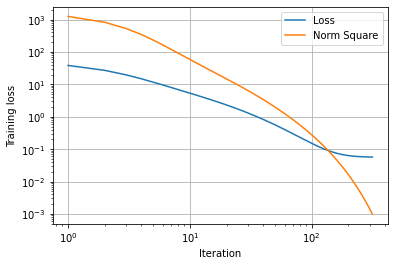

In [28]:
t = np.arange(len(Jhist))+1
plt.semilogx(t, Jhist)
plt.semilogy(t, gnormhist)
plt.legend(['Loss', 'Norm Square'])
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Training loss')


## Problem 2.   SVM

We consider a simple binary classification problem of discriminating between MNIST digits with class `5` (label `y=-1`)
and class `6` (label `y=1`).  To make the problem simple, we have randomly selected 100 digits for training and test for each class.  
  
Run the following command which loads the data and plot examples from the training data set and the binary labels.

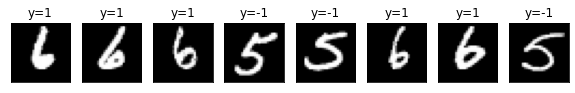

In [29]:
with open('prob_svm.p', 'rb') as fp:
    Xtr,Xts,ytr,yts = pickle.load(fp)
    

def plt_digit(ax, x):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    ax.imshow(xsq,  cmap='Greys_r')
    ax.set_xticks([])
    ax.set_yticks([])

# Select random digits
ntr = Xtr.shape[0]
nplt = 8
Iperm = np.random.permutation(ntr)

# Plot the images using the subplot command
fig, ax = plt.subplots(1,nplt,figsize=(10,3))
for i in range(nplt):
    ind = Iperm[i]
    plt_digit(ax[i], Xtr[ind,:])
    ax[i].set_title('y=%d' % ytr[ind])

Print the shape of `Xtr` and `Xts`.

In [30]:
# TODO
print("Shape of Xtr: ", Xtr.shape)
print("Shape of Xts: ", Xts.shape)

Shape of Xtr:  (200, 28, 28)
Shape of Xts:  (200, 28, 28)


Consider a simple kernel classifier:
        
    z[i] = \sum_j K(Xts[i,:,:], Xtr[j,:,:])*ytr[j]
    yhat[i] = sign( z[i] )
    
We use a radial basis function kernel:

    K(x0, x1) = exp( -gam*||x0-x1||^2 )
    
where `||x0-x1||^2` is the squared distance between images `x0` and `x1`.

Complete the function `predict` below that implements this kernel classifier.
For full credit, avoid for loops.

In [31]:
def predict(Xts, Xtr, ytr, gam):
    
    # reshape Xts and Xtr for broadcasting
    Xts = Xts[None,:,:,:]
    Xtr = Xtr[:,None,:,:]
    D = (Xts - Xtr)**2
    K = np.exp(-gam * D)
    z = np.sum(K * ytr[:,None,None,None], axis=(0, 2, 3))
    yhat = np.sign(z)
    return yhat

What is the test accuracy you get with `gam = 0.01`?

In [32]:
# TODO
yhat = predict(Xts, Xtr, ytr, gam=0.01)
acc = np.mean(yhat == yts)
print("Test accuracy: ", acc)

Test accuracy:  0.96


Create a new test data set, `Xts_shift`, where each image `Xts_shift[i,:,:]` is the image `Xts[i,:,:]` shifted two columns to the right.  The first two columns of `Xts_shift[i,:,:]` are zero.  What is the test accuracy of the classifer using `Xts_shift` and `gam=0.01`?

In [33]:
s = 2  # Shift amount to the right

# TODO 
Xts_shift = np.dstack((np.zeros((200, 28, 2)), Xts[:,:,:26]))
print(Xts_shift.shape)
yhat_shift = predict(Xts_shift, Xtr, ytr, gam=0.01)
acc = np.mean(yhat_shift==yts)
print("Test accuracy: ", acc)

(200, 28, 28)
Test accuracy:  0.93


## Problem 3.  Neural Networks

Run the following code to load the training and test data:

In [34]:
with open('prob_nn.p', 'rb') as fp:
    Xtr,Xts,ytr,yts = pickle.load(fp)

In [35]:
print(Xtr.shape)
print(ytr.shape)

(500, 2)
(500,)


Create a tensorflow model, `model` to map the data `x` to `yhat` as follows:

* Clear the tensorflow session
* Create a `Sequential` model, `model`.
* Add one single hidden layer with the  number of inputs based on the shape of the training data `Xtr`.  Use `nh=8` hidden units and a `sigmoid` activation
* Add an output layer.  Select the number of ouputs based on the shape of the training outputs `ytr`.  Select the activation assuming the model is for regression (that is, `y` is a continuous valued target).
* Print the model summary

In [36]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.backend as K

# Clear session
K.clear_session()

# Network metadata
nin = Xtr.shape[1]
nh = 8
nout = 1

model = Sequential()
model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(units=nout, activation='linear', name='output'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 8)                 24        
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


Fit the model on the training data `Xtr, ytr`:

* Use the `Adam` optimizer with `lr=0.01`.
* Compile the model.  Select the correct `loss` and `metrics` for regression
* Run the `model.fit` with a batch size of 32, 500 epochs and `verbose=False`.
* Save the loss history in `hist`.

In [37]:
from tensorflow.keras import optimizers

# TODO
opt = optimizers.Adam(lr=0.01)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_squared_error'])
hist = model.fit(Xtr, ytr, batch_size=32, epochs=500, verbose=False)

C:\Users\willi\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Plot the loss history as a function of the epochs. Label the graph.

Text(0, 0.5, 'loss')

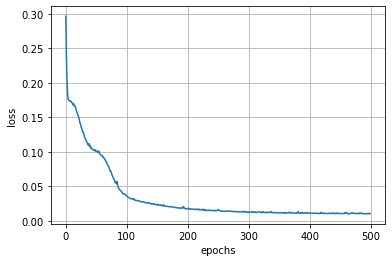

In [38]:
# TODO
loss = hist.history['mean_squared_error']

plt.plot(loss)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')

Compute and print the mean absolute error (MAE) on the test data.  The MAE is defined as:

    MAE = (1/n)*\sum_i |yhat[i] - y[i]|
    
where `n` is the number of samples.

In [39]:
# TODO
yhat_ts = model.predict(Xts)
mae = np.mean(np.abs(yhat_ts[:,0] - yts))
print("Mean Absolute Error: ", mae)

Mean Absolute Error:  0.08656180580170897


Plot the predicted response `yhat` vs. `x1` on the set of points `x=[x0,x1]` where `x0=0` and `x1` ranges from -1 to 1. 

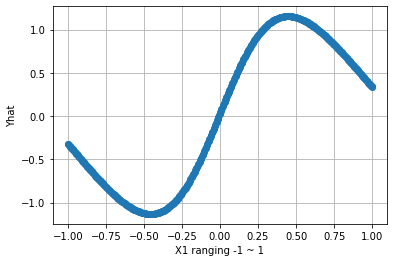

In [40]:
x = np.column_stack((np.zeros((500, 1)), np.linspace(-1, 1, 500)))
yhat = model.predict(x)

plt.plot(x[:,1], yhat, 'o')
plt.xlabel("X1 ranging -1 ~ 1")
plt.ylabel("Yhat")
plt.grid()